# Data Preparation

## Library

In [ ]:
%%capture
!pip install jcopml
!pip install category_encoders
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

## Load Data

In [ ]:
!gdown 1NJ7DsgZ3zIdZWTz17RQWgbtDBuk1JVg3

Downloading...
From: https://drive.google.com/uc?id=1NJ7DsgZ3zIdZWTz17RQWgbtDBuk1JVg3
To: /content/data_california_house.csv
100% 1.01M/1.01M [00:00<00:00, 61.7MB/s]


In [ ]:
df = pd.read_csv("data_california_house.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


| Fitur              | Deskripsi                                                                 |
|--------------------|---------------------------------------------------------------------------|
| **longitude**|  Ukuran seberapa jauh ke arah barat sebuah rumah di sebelah barat.                                                      |
| **latitude**| Ukuran seberapa jauh ke utara sebuah rumah.                                             |
| **housing_median_age**| Usia rata-rata sebuah rumah dalam satu blok; angka yang lebih rendah adalah bangunan yang lebih baru.                                          |
| **total_rooms**|  Jumlah total kamar tidur dalam satu blok.|
| **population**|  Jumlah total orang yang tinggal di dalam blok.                                        |
| **households**| Jumlah total rumah tangga, sekelompok orang yang tinggal di dalam satu unit rumah, untuk satu blok.                                           |
| **median_income**| Pendapatan rata-rata rumah tangga di dalam satu blok rumah (diukur dalam puluhan ribu Dolar AS).                                       |
| **ocean_proximity**| Lokasi rumah yang dekat dengan samudra/laut.                              |
| **median_house_value**|  Nilai rata-rata rumah untuk rumah tangga dalam satu blok (diukur dalam Dolar AS).           |




Penjelasan tentang isi dari kolom ocean_proximity.

| Isi Data              | Penjelasan                                                                 |
|--------------------|---------------------------------------------------------------------------|
| **ISLAND**|  Ini menunjukkan rumah tersebut terletak di sebuah pulau.                                                      |
| **<1H OCEAN**| Ini menandakan rumah tersebut berjarak kurang dari satu jam dari laut.                                             |
| **NEAR OCEAN**| Rumah tersebut lebih dekat dengan lautan ketimbang `<1H OCEAN.                                          |
| **NEAR BAY**|  Rumah tersebut berada di dekat teluk, yang merupakan perairan yang terhubung ke lautan atau danau.|
| **INLAND**|  Rumah tersebut tidak berada di dekat pantai, melainkan berada di pedalaman.                                        |

# Delete Outliers (Experiment 2)

## IQR (R² 0.823729, MAE 26980.545022)

In [ ]:
# Improved IQR outlier removal function
def remove_outliers_iqr(data, numerical_features):
    Q1 = data[numerical_features].quantile(0.25)
    Q3 = data[numerical_features].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = ~((data[numerical_features] < lower_bound) | (data[numerical_features] > upper_bound)).any(axis=1)
    return data[mask], mask

# Improved cross-validation function
def perform_cross_validation(X_train, y_train, models, preprocessor):
    results = {}
    scorers = {
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
        'R²': make_scorer(r2_score)
    }
    # KFold for reproducibility
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        # Cross-validation on training data
        cv_results = {metric: cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer).mean() for metric, scorer in scorers.items()}

        # Store the cross-validation results
        results[model_name] = {
            'CV MAE': -cv_results['MAE'],
            'CV MSE': -cv_results['MSE'],
            'CV RMSE': -cv_results['RMSE'],
            'CV R²': cv_results['R²'],
        }

    return pd.DataFrame(results).T.sort_values(by='CV RMSE', ascending=True)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Selected models
selected_models = {
    "LightGBM": LGBMRegressor(random_state=42, force_col_wise=True),
    "XGBoost": XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Remove outliers with IQR
X_train_iqr_filtered, iqr_mask = remove_outliers_iqr(X_train, numerical_features)
y_train_iqr_filtered = y_train.loc[iqr_mask]

# Ensure filtered data is not empty
if X_train_iqr_filtered.empty:
    raise ValueError("No data left after IQR filtering. Adjust the filtering criteria.")

# Cross-validation with IQR filtered data
cv_results_iqr = perform_cross_validation(X_train_iqr_filtered, y_train_iqr_filtered, selected_models, preprocessor)

# Create a table for easy reference
table = cv_results_iqr.reset_index()
table.rename(columns={'index': 'Model Name'}, inplace=True)

# Print cross-validation results and formatted table
print("Cross-validation results after IQR outlier removal:")
print(cv_results_iqr)

print("\nFormatted Table:")
print(table)

# Displaying the table as a DataFrame
table

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 18
[LightGBM] [Info] Start training from score 182299.442391


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181723.987798


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 182263.015970


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 180649.468150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181036.226270


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 18
[LightGBM] [Info] Start training from score 182299.442391


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181723.987798


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 182263.015970


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 180649.468150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181036.226270


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 18
[LightGBM] [Info] Start training from score 182299.442391


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181723.987798


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 182263.015970


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 180649.468150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181036.226270


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 18
[LightGBM] [Info] Start training from score 182299.442391


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181723.987798


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 182263.015970


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 180649.468150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 5573, number of used features: 18
[LightGBM] [Info] Start training from score 181036.226270


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cross-validation results after IQR outlier removal:
                     CV MAE        CV MSE       CV RMSE     CV R²
LightGBM       26980.545022  1.703011e+09  41255.199534  0.823729
XGBoost        27920.361352  1.813622e+09  42574.182026  0.812313
Random Forest  29216.155049  1.992001e+09  44612.949004  0.794015

Formatted Table:
      Model Name        CV MAE        CV MSE       CV RMSE     CV R²
0       LightGBM  26980.545022  1.703011e+09  41255.199534  0.823729
1        XGBoost  27920.361352  1.813622e+09  42574.182026  0.812313
2  Random Forest  29216.155049  1.992001e+09  44612.949004  0.794015


,Model Name,CV MAE,CV MSE,CV RMSE,CV R²
0,LightGBM,26980.545022,1.703011e+09,41255.199534,0.823729
1,XGBoost,27920.361352,1.813622e+09,42574.182026,0.812313
2,Random Forest,29216.155049,1.992001e+09,44612.949004,0.794015


In [ ]:
# cek parameter default lightgbm
lgbm_params = LGBMRegressor().get_params()
lgbm_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Kategori di X_train_iqr_filtered['ocean_proximity']: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
Kategori di X_test['ocean_proximity']: ['INLAND' 'NEAR OCEAN' '<1H OCEAN' 'NEAR BAY']
Kolom di X_train: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Kolom di X_test: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Shape X_train_iqr_filtered: (9257, 16) Shape y_train_iqr_filtered: (9257,)
Shape X_t

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


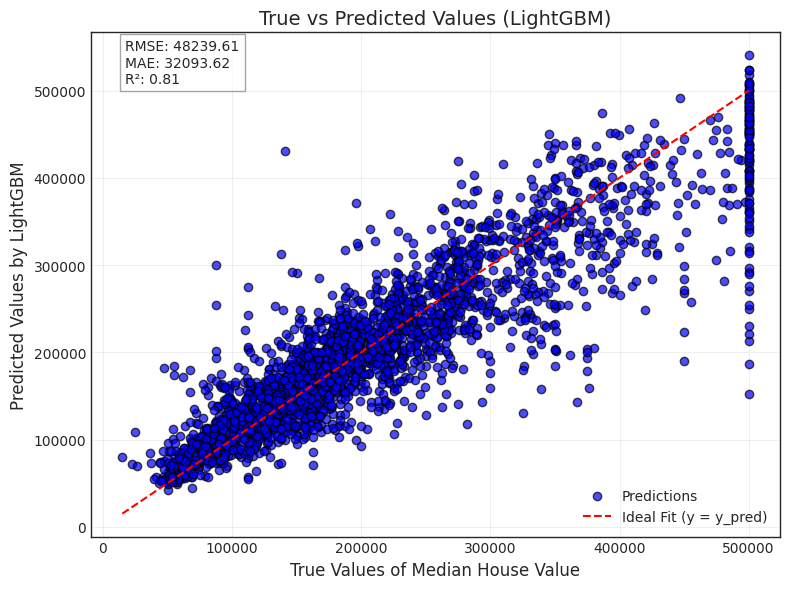

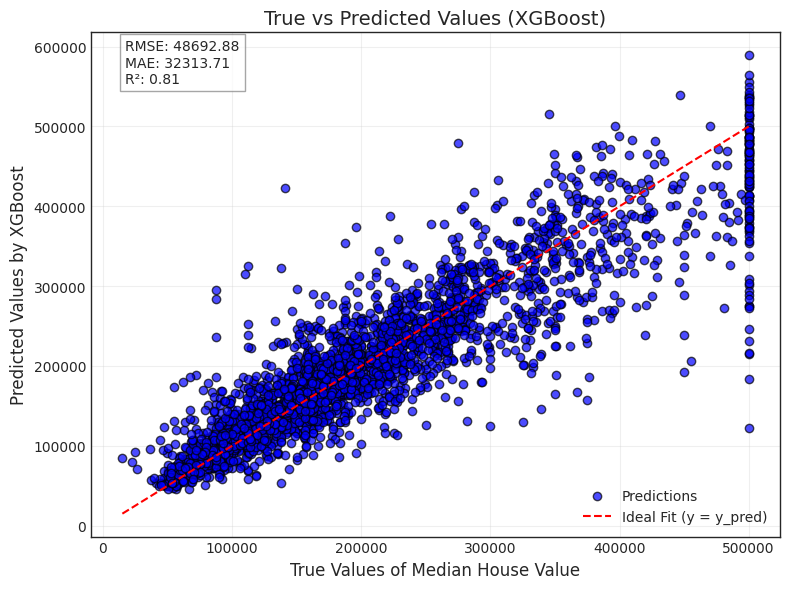

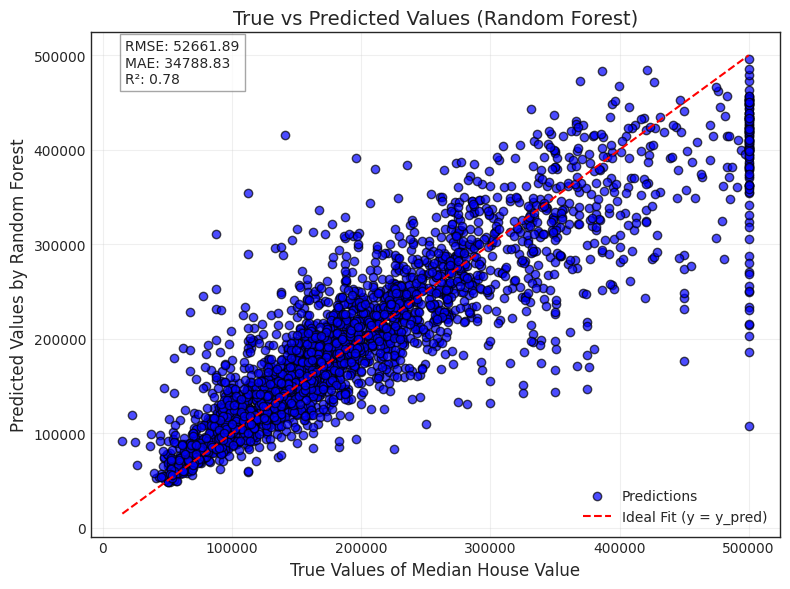

Hasil Evaluasi pada Data Test:
                   Test MAE      Test MSE     Test RMSE   Test R²
LightGBM       32093.618319  2.327060e+09  48239.610101  0.812872
XGBoost        32313.711893  2.370997e+09  48692.880224  0.809339
Random Forest  34788.830754  2.773275e+09  52661.889372  0.776990

Formatted Table:
      Model Name      Test MAE      Test MSE     Test RMSE   Test R²
0       LightGBM  32093.618319  2.327060e+09  48239.610101  0.812872
1        XGBoost  32313.711893  2.370997e+09  48692.880224  0.809339
2  Random Forest  34788.830754  2.773275e+09  52661.889372  0.776990


,Model Name,Test MAE,Test MSE,Test RMSE,Test R²
0,LightGBM,32093.618319,2.327060e+09,48239.610101,0.812872
1,XGBoost,32313.711893,2.370997e+09,48692.880224,0.809339
2,Random Forest,34788.830754,2.773275e+09,52661.889372,0.776990


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Asumsikan Anda memiliki:
# - X_train, y_train: data pelatihan
# - X_test, y_test: data pengujian
# - numerical_features: daftar kolom numerik
# - categorical_features: daftar kolom kategorikal

# Definisikan numerical_features dan categorical_features
numerical_features = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
    'population', 'households', 'median_income', 'rooms_per_household',
    'population_per_household', 'bedroom_ratio', 'income_per_person', 'income_level'
]
categorical_features = ['ocean_proximity', 'house_age_category', 'is_coastal']

# Periksa kategori di ocean_proximity
print("Kategori di X_train_iqr_filtered['ocean_proximity']:", X_train['ocean_proximity'].unique())
print("Kategori di X_test['ocean_proximity']:", X_test['ocean_proximity'].unique())

# Improved IQR outlier removal function
def remove_outliers_iqr(data, numerical_features):
    Q1 = data[numerical_features].quantile(0.25)
    Q3 = data[numerical_features].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = ~((data[numerical_features] < lower_bound) | (data[numerical_features] > upper_bound)).any(axis=1)
    return data[mask], mask

# Preprocessing pipeline dengan SimpleImputer dan handle_unknown='ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Tangani NaN
            ('scaler', RobustScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Tangani NaN
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Selected models
selected_models = {
    "LightGBM": LGBMRegressor(random_state=42, force_col_wise=True),
    "XGBoost": XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Remove outliers with IQR on training data
X_train_iqr_filtered, iqr_mask = remove_outliers_iqr(X_train, numerical_features)
y_train_iqr_filtered = y_train[iqr_mask]  # Gunakan indexing langsung untuk y_train

# Ensure filtered data is not empty
if X_train_iqr_filtered.empty:
    raise ValueError("No data left after IQR filtering. Adjust the filtering criteria.")

# Periksa data
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)
print("Shape X_train_iqr_filtered:", X_train_iqr_filtered.shape, "Shape y_train_iqr_filtered:", y_train_iqr_filtered.shape)
print("Shape X_test:", X_test.shape, "Shape y_test:", y_test.shape)

# Evaluasi pada data test
test_results = {}

for model_name, model in selected_models.items():
    # Buat pipeline dengan preprocessing dan model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Latih model pada data train yang sudah difilter
    pipeline.fit(X_train_iqr_filtered, y_train_iqr_filtered)

    # Prediksi pada data test
    y_pred = pipeline.predict(X_test)

    # Hitung metrik evaluasi pada data test
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)

    # Simpan hasil evaluasi
    test_results[model_name] = {
        'Test MAE': test_mae,
        'Test MSE': test_mse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    }

    # Visualisasi: Scatter plot untuk true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='k', label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit (y = y_pred)')

    # Tambahkan label, judul, dan legenda
    plt.xlabel("True Values of Median House Value", fontsize=12)
    plt.ylabel(f"Predicted Values by {model_name}", fontsize=12)
    plt.title(f"True vs Predicted Values ({model_name})", fontsize=14)
    plt.legend(fontsize=10)

    # Tambahkan metrik ke plot
    plt.text(
        0.05, 0.9,
        f"RMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nR²: {test_r2:.2f}",
        fontsize=10,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
    )

    # Tampilkan plot
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Konversi hasil test ke DataFrame
test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.sort_values(by='Test RMSE', ascending=True)

# Buat tabel untuk referensi
test_table = test_results_df.reset_index()
test_table.rename(columns={'index': 'Model Name'}, inplace=True)

# Tampilkan hasil
print("Hasil Evaluasi pada Data Test:")
print(test_results_df)

print("\nFormatted Table:")
print(test_table)

# Tampilkan tabel sebagai DataFrame
test_table

# HyperParameter Tuning (Experiment 3)

## LightGBM - RandomSearchCV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

# Custom scorer definitions
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom scorers for RandomizedSearchCV
mse_scorer = make_scorer(mse, greater_is_better=False)
mae_scorer = make_scorer(mae, greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Scoring dictionary with only positive metrics
scoring = {
    "mse": mse_scorer,  # Minimizing MSE
    "mae": mae_scorer,  # Minimizing MAE
    "rmse": rmse_scorer,  # Minimizing RMSE
    "r2": r2_scorer  # Maximizing R²
}

# Define the parameter grid for LightGBM
param_grid_complex = {
    'model__n_estimators': [200, 400, 600],  # Banyak pohon untuk menangkap pola kompleks
    'model__learning_rate': [0.005, 0.01, 0.05],  # Learning rate kecil untuk belajar mendalam
    'model__max_depth': [10, 15, -1],  # Pohon dalam untuk menangkap hubungan rumit
    'model__num_leaves': [50, 100, 150],  # Banyak daun untuk model detail
    'model__subsample': [0.6, 0.8, 1.0],  # Variasi subsampling untuk mencegah overfitting
    'model__colsample_bytree': [0.6, 0.8, 1.0]  # Variasi fitur untuk fleksibilitas
}

# Create the LightGBM model
lgbm_model = LGBMRegressor(random_state=42, force_col_wise=True)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', lgbm_model)])

# Set up Randomized Search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_complex,  # Gunakan param_grid yang sama
    n_iter=50,  # Jumlah kombinasi parameter yang akan dicoba secara acak
    scoring=scoring,  # Evaluate multiple metrics
    refit="mae",  # Select the best model based on MAE
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42,  # Untuk reproduktibilitas
    return_train_score=True,
)

# Fit the model with Randomized Search
random_search.fit(X_train, y_train)

# Extract and format the results
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_rmse", ascending=True)

# Display the best parameters and the sorted results
print("Best Parameters:", random_search.best_params_)

# Extracting metrics for the best parameters
best_index = random_search.best_index_  # Index of the best parameter combination

# Create a DataFrame for the best results
best_results = pd.DataFrame({
    "CV MAE": [-cv_results.loc[best_index, "mean_test_mae"]],  # Flip sign to get positive value
    "CV MSE": [-cv_results.loc[best_index, "mean_test_mse"]],  # Flip sign to get positive value
    "CV RMSE": [-cv_results.loc[best_index, "mean_test_rmse"]],  # Flip sign to get positive value
    "CV R²": [cv_results.loc[best_index, "mean_test_r2"]],
})

# Display the best parameters and the summary table
print("\nSummary of Best Results:")
print(best_results)

# Return the sorted results for inspection
cv_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2877
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 21
[LightGBM] [Info] Start training from score 207167.999563
Best Parameters: {'model__subsample': 0.6, 'model__num_leaves': 50, 'model__n_estimators': 400, 'model__max_depth': -1, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}

Summary of Best Results:
        CV MAE        CV MSE       CV RMSE     CV R²
0  29706.58561  2.122229e+09  46062.476168  0.842837


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__num_leaves,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
32,1.458852,0.079897,0.151162,0.041700,0.6,50,200,-1,0.005,0.6,...,0.652567,0.004053,50,0.677398,0.675259,0.673945,0.679270,0.674714,0.676117,0.001949
26,1.102396,0.012702,0.079282,0.002559,1.0,50,200,-1,0.005,0.8,...,0.660083,0.003742,49,0.685173,0.681810,0.681655,0.686868,0.682399,0.683581,0.002078
4,1.472462,0.247824,0.090370,0.027159,1.0,50,200,15,0.005,1.0,...,0.660641,0.003573,48,0.686631,0.682430,0.682283,0.688242,0.683601,0.684637,0.002386
17,2.161344,0.403728,0.130575,0.041179,0.6,150,200,15,0.005,0.6,...,0.674060,0.003838,47,0.720256,0.717673,0.717006,0.721900,0.717983,0.718964,0.001830
45,1.777328,0.028444,0.091215,0.001026,1.0,100,200,15,0.005,0.8,...,0.675487,0.003938,46,0.713744,0.710188,0.710440,0.715424,0.711598,0.712279,0.002013
2,2.239351,0.359391,0.107746,0.038842,1.0,100,200,-1,0.005,0.8,...,0.675504,0.003890,45,0.713828,0.710188,0.710441,0.715426,0.711379,0.712252,0.002042
7,0.910429,0.050820,0.084439,0.005150,0.6,50,200,10,0.010,0.6,...,0.775107,0.006908,44,0.813247,0.809992,0.808896,0.815387,0.810179,0.811540,0.002406
49,3.004962,0.536579,0.139231,0.036363,0.6,50,400,15,0.005,1.0,...,0.775522,0.007149,43,0.816552,0.811769,0.811392,0.819351,0.813822,0.814577,0.003010
38,2.263799,0.573505,0.223267,0.048282,0.8,50,400,10,0.005,0.6,...,0.775613,0.006855,42,0.814061,0.811058,0.809514,0.816354,0.811160,0.812429,0.002452
33,2.868303,0.873642,0.237926,0.088446,1.0,50,400,-1,0.005,0.6,...,0.775942,0.007102,41,0.814951,0.811848,0.810200,0.816953,0.811941,0.813179,0.002432


Kolom di X_train: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Kolom di X_test: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household',
       'bedroom_ratio', 'income_per_person', 'is_coastal',
       'house_age_category', 'income_level'],
      dtype='object')
Shape X_train: (11448, 16) Shape y_train: (11448,)
Shape X_test: (2863, 16) Shape y_test: (2863,)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


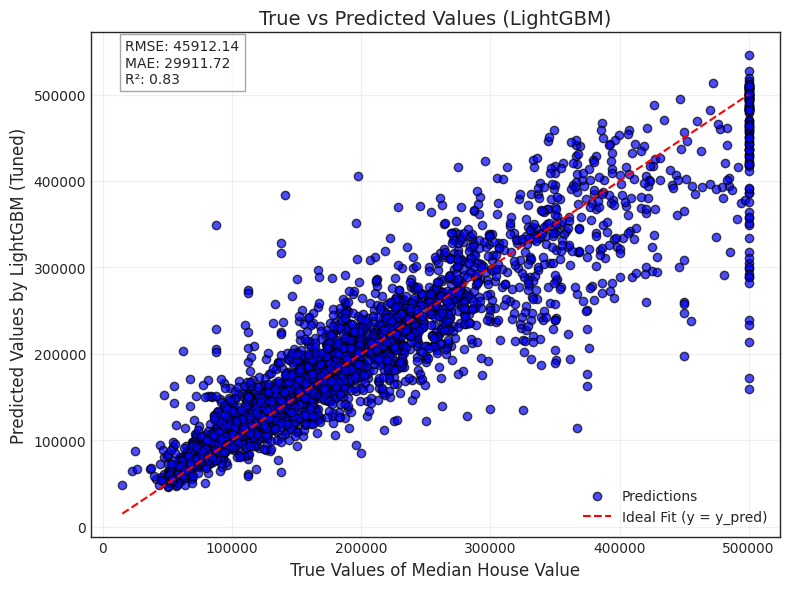

Hasil Evaluasi pada Data Test:
                      Test MAE      Test MSE     Test RMSE   Test R²
LightGBM (Tuned)  29911.717857  2.107925e+09  45912.144109  0.830493


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Asumsikan Anda sudah memiliki:
# - X_train, y_train: data pelatihan
# - X_test, y_test: data pengujian
# - random_search: objek RandomizedSearchCV yang sudah di-fit dari kode sebelumnya
# - preprocessor: ColumnTransformer yang sudah dikonfigurasi

# Periksa kolom di X_train dan X_test
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)
print("Shape X_train:", X_train.shape, "Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape, "Shape y_test:", y_test.shape)

# Ambil model terbaik dari RandomizedSearchCV
best_model = random_search.best_estimator_

# Prediksi pada data test menggunakan model terbaik
y_pred = best_model.predict(X_test)

# Hitung metrik evaluasi pada data test
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Simpan hasil evaluasi dalam dictionary
test_results = {
    'LightGBM (Tuned)': {
        'Test MAE': test_mae,
        'Test MSE': test_mse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    }
}

# Visualisasi: Scatter plot untuk true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit (y = y_pred)')

# Tambahkan label, judul, dan legenda
plt.xlabel("True Values of Median House Value", fontsize=12)
plt.ylabel("Predicted Values by LightGBM (Tuned)", fontsize=12)
plt.title("True vs Predicted Values (LightGBM)", fontsize=14)
plt.legend(fontsize=10)

# Tambahkan metrik ke plot
plt.text(
    0.05, 0.9,
    f"RMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nR²: {test_r2:.2f}",
    fontsize=10,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

# Tampilkan plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Konversi hasil test ke DataFrame
test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.sort_values(by='Test RMSE', ascending=True)

# Tampilkan hasil
print("Hasil Evaluasi pada Data Test:")
print(test_results_df)

## LightGBM - GridSearch CV (R² 0.843561, MAE 29654.76946)

In [ ]:
# Custom scorer definitions
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom scorers for GridSearchCV
mse_scorer = make_scorer(mse, greater_is_better=False)
mae_scorer = make_scorer(mae, greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Scoring dictionary with only positive metrics
scoring = {
    "mse": mse_scorer,  # Minimizing MSE
    "mae": mae_scorer,  # Minimizing MAE
    "rmse": rmse_scorer,  # Minimizing RMSE
    "r2": r2_scorer  # Maximizing R²
}

# Define the parameter grid for LightGBM
param_grid_complex = {
    'model__n_estimators': [200, 400, 600],  # Banyak pohon untuk menangkap pola kompleks
    'model__learning_rate': [0.005, 0.01, 0.05],  # Learning rate kecil untuk belajar mendalam
    'model__max_depth': [10, 15, -1],  # Pohon dalam untuk menangkap hubungan rumit
    'model__num_leaves': [50, 100, 150],  # Banyak daun untuk model detail
    'model__subsample': [0.6, 0.8, 1.0],  # Variasi subsampling untuk mencegah overfitting
    'model__colsample_bytree': [0.6, 0.8, 1.0]  # Variasi fitur untuk fleksibilitas
}

# Create the LightGBM model
lgbm_model = LGBMRegressor(random_state=42, force_col_wise=True)

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', lgbm_model)])

# Set up Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid_complex,
    scoring=scoring,  # Evaluate multiple metrics
    refit="mae",  # Select the best model based on MAE
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
)

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

# Extract and format the results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_rmse", ascending=True)
cv_results

# Display the best parameters and the sorted results
print("Best Parameters:", grid_search.best_params_)

# Extracting metrics for the best parameters
best_index = grid_search.best_index_  # Index of the best parameter combination

# Create a DataFrame for the best results
best_results = pd.DataFrame({
    "CV MAE": [-cv_results.loc[best_index, "mean_test_mae"]],  # Flip sign to get positive value
    "CV MSE": [-cv_results.loc[best_index, "mean_test_mse"]],  # Flip sign to get positive value
    "CV RMSE": [-cv_results.loc[best_index, "mean_test_rmse"]],  # Flip sign to get positive value
    "CV R²": [cv_results.loc[best_index, "mean_test_r2"]],
})

# Display the best parameters and the summary table
print("\nSummary of Best Results:")
best_results

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 21
[LightGBM] [Info] Start training from score 207167.999563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 15, 'model__n_estimators': 600, 'model__num_leaves': 50, 'model__subsample': 0.6}

Summary of Best Results:


,CV MAE,CV MSE,CV RMSE,CV R²
0,29654.76946,2.112529e+09,45960.070905,0.843561


# Feature Importance

## Feature Importance

<ipython-input-42-92ca71ff05cb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')


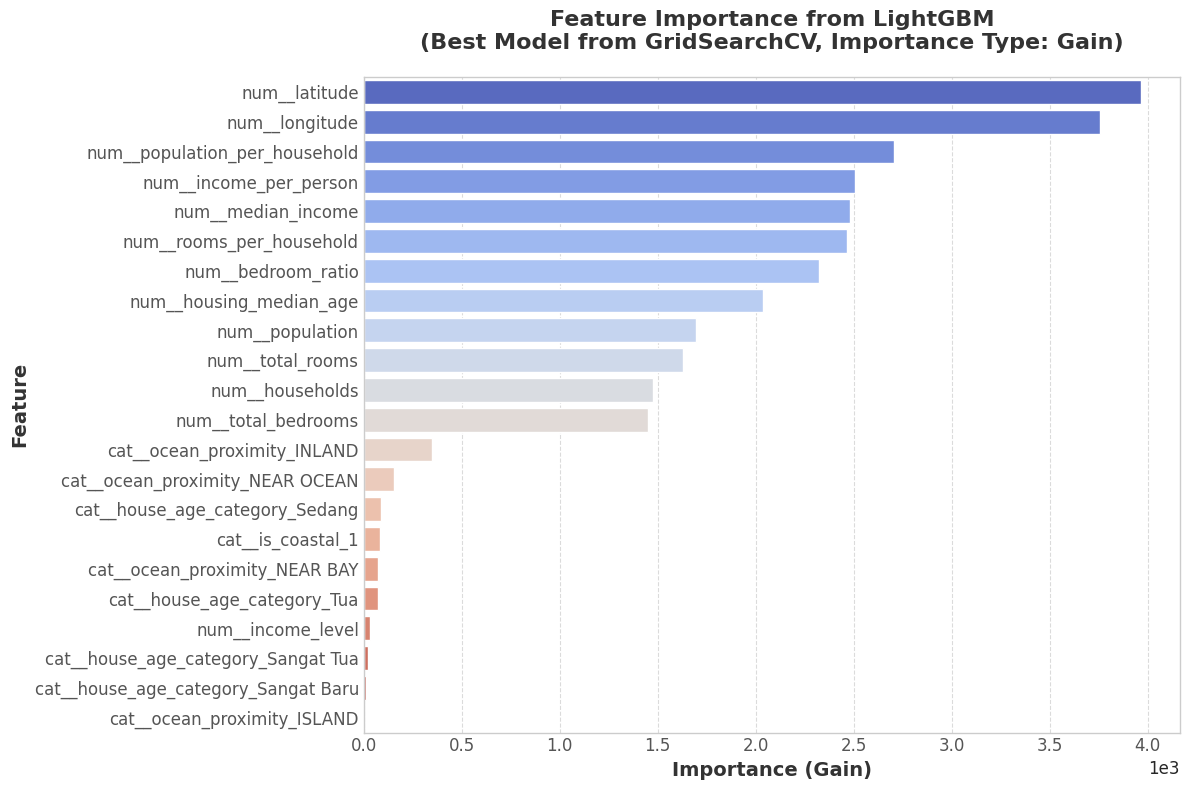


Feature Importance (Top 10):
                          Feature  Importance
1                   num__latitude        3967
0                  num__longitude        3756
9   num__population_per_household        2706
11         num__income_per_person        2509
7              num__median_income        2480
8        num__rooms_per_household        2468
10             num__bedroom_ratio        2322
2         num__housing_median_age        2037
5                 num__population        1694
3                num__total_rooms        1630


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract the best model from GridSearchCV (assuming grid_search is already defined)
best_model = grid_search.best_estimator_

# Step 2: Access the LightGBM model from the pipeline
lgbm_best = best_model.named_steps['model']

# Step 3: Extract feature importance (using "gain" method by default)
feature_importances = lgbm_best.feature_importances_

# Step 4: Get feature names after preprocessing using get_feature_names_out()
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Step 5: Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Step 6: Visualize feature importance with enhanced aesthetics
plt.figure(figsize=(12, 8))  # Slightly larger figure for better readability
sns.set_style("whitegrid")  # Add a light grid background for better readability

# Use a more vibrant and gradient color palette
bar_plot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')

# Customize the title and labels with larger, bold fonts
plt.title('Feature Importance from LightGBM\n(Best Model from GridSearchCV, Importance Type: Gain)',
          fontsize=16, fontweight='bold', pad=20, color='#333333')
plt.xlabel('Importance (Gain)', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Feature', fontsize=14, fontweight='bold', color='#333333')

# Customize tick labels for better readability
plt.xticks(fontsize=12, color='#555555')
plt.yticks(fontsize=12, color='#555555')

# Format the x-axis to use scientific notation for large values
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_fontsize(12)  # Adjust the scientific notation font size

# Add a subtle grid on the x-axis for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Display the feature importance DataFrame (Top 10)
print("\nFeature Importance (Top 10):")
print(feature_importance_df.head(10))


1.   Latitude dan Longitude (num__latitude, num__longitude):

*   Fitur paling kritis, menunjukkan ketergantungan spasial (lokasi) yang kuat terhadap nilai rumah.

2.   Population Per Household (num__population_per_household):

*   Peringkat ketiga, mencerminkan pentingnya kepadatan populasi dan ukuran rumah tangga dalam prediksi nilai rumah.

3.   Median Income (num__median_income):

*   Faktor utama, menunjukkan hubungan langsung antara tingkat pendapatan dan harga rumah.

4.   Bedroom Ratio dan Room Per Household (num__bedrooms_ratio, num__rooms_per_household):
*   Secara signifikan memengaruhi nilai rumah, menyoroti komposisi rumah sebagai faktor kunci.


5.   Housing Median Age (num__housing_median_age):

*   Cukup penting, menunjukkan relevansi usia properti dalam menentukan nilai.


6.   Ocean Proximity (cat__ocean_proximity):

*   Variabel kategorikal yang berkontribusi sedikit. Hanya INLAND yang memiliki beberapa pentingnya, sedangkan NEAR BAY dan lainnya memiliki pengaruh kecil.


7.   Ringkasan Referensi: Model lebih memprioritaskan lokasi (latitude, longitude), karakteristik rumah tangga (income, rooms), dan usia properti, dibandingkan variabel kategorikal seperti kedekatan ke laut.












## Save Model

In [ ]:
import joblib

# Save the entire pipeline (including preprocessor and model) to a .pkl file
joblib.dump(best_model, "the_best_lightgbm_model.pkl")
print("Model saved as '*the_best_lightgbm_model.pkl'")

# Load the model later (example code for reference)
# loaded_model = joblib.load("the_best_lightgbm_model.pkl")

Model saved as '*the_best_lightgbm_model.pkl'


In [ ]:
# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the model's performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display the results
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test MAE: 29497.1356
Test MSE: 2074430098.9714
Test RMSE: 45545.9120
Test R²: 0.8332


*   MAE: Rata-rata kesalahan prediksi adalah sekitar $29,497, artinya prediksi Anda bisa meleset sekitar segitu dari nilai asli dalam dolar.
*   RMSE: Nilai ini (45,545) lebih besar dari MAE karena mempertimbangkan kesalahan kuadrat, menunjukkan adanya variasi kesalahan yang lebih besar, terutama pada prediksi yang jauh menyimpang. Ini tetap menandakan model Anda cukup akurat untuk harga rumah.
*   MSE: Memberikan bobot lebih pada kesalahan besar, tapi lebih berguna untuk analisis matematis, dengan nilai 2,074,430,098.
*   R²: 0.8332 berarti model menjelaskan 83.32% variasi harga rumah, yang sangat baik, dengan sisanya (sekitar 16.68%) mungkin disebabkan oleh faktor lain atau noise.










# Rules Based Prediction

## Rule Based Prediction

In [ ]:
import pandas as pd

# Fungsi untuk memprediksi nilai rumah median berdasarkan fitur yang dipilih
def predict_median_house_value(latitude, longitude, median_income, income_per_person, population_per_household):
    """
    Fungsi untuk memprediksi nilai rumah median berdasarkan latitude, longitude,
    median_income, income_per_person, dan population_per_household.

    Parameter:
    - latitude: Lintang lokasi rumah (koordinat geografis)
    - longitude: Bujur lokasi rumah (koordinat geografis)
    - median_income: Pendapatan rata-rata daerah
    - income_per_person: Pendapatan rata-rata per orang
    - population_per_household: Jumlah orang per rumah tangga (kepadatan)

    Mengembalikan:
    - median_house_value: Nilai rumah median yang diprediksi dalam dolar
    """

    # Tentukan nilai dasar rumah berdasarkan gabungan pendapatan daerah dan per orang
    combined_income_factor = (median_income + income_per_person) / 2  # Rata-rata pengaruh pendapatan
    if combined_income_factor < 2.0:  # Daerah berpendapatan rendah
        median_house_value = 120000  # Nilai dasar untuk daerah berpendapatan rendah
    elif combined_income_factor < 3.5:  # Daerah berpendapatan menengah-rendah
        median_house_value = 180000
    elif combined_income_factor < 6.0:  # Daerah berpendapatan menengah-tinggi
        median_house_value = 300000
    else:  # Daerah berpendapatan tinggi
        median_house_value = 500000  # Nilai dasar untuk daerah berpendapatan tinggi

    # Sesuaikan berdasarkan lokasi (latitude dan longitude sebagai fitur utama)
    # Simulasikan lokasi urban/premium (misalnya, dekat kota besar atau pantai)
    if 33.0 <= latitude <= 34.5 and -118.5 <= longitude <= -117.0:  # Sekitar wilayah Los Angeles
        median_house_value *= 1.20  # Naikkan 20% untuk lokasi urban premium
    elif 36.5 <= latitude <= 38.0 and -122.0 <= longitude <= -120.0:  # Sekitar wilayah SF Bay Area
        median_house_value *= 1.25  # Naikkan 25% untuk lokasi pesisir premium

    # Sesuaikan berdasarkan kepadatan penduduk per rumah tangga (faktor kepadatan)
    if population_per_household > 3.5:  # Kepadatan tinggi
        median_house_value *= 0.92  # Turunkan 8% karena overcrowding
    elif population_per_household < 2.0:  # Kepadatan rendah
        median_house_value *= 1.05  # Naikkan 5% untuk daerah yang lebih luas dan nyaman

    # Pastikan nilai berada dalam rentang yang realistis
    median_house_value = max(50000, min(median_house_value, 1000000))  # Batas antara $50k dan $1M

    return median_house_value

# Terapkan fungsi ke setiap baris di DataFrame
df['rule_predicted'] = df.apply(lambda row: predict_median_house_value(
    latitude=row['latitude'],
    longitude=row['longitude'],
    median_income=row['median_income'],
    income_per_person=row['income_per_person'],
    population_per_household=row['population_per_household']
), axis=1)

# Tampilkan DataFrame yang telah diperbarui
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,rooms_per_household,population_per_household,bedroom_ratio,income_per_person,is_coastal,house_age_category,income_level,rule_predicted
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0,2.800000,4.825000,0.250000,0.409326,0,Sangat Tua,1,110400.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0,3.671480,3.018051,0.322517,0.748960,1,Sangat Tua,1,120000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0,6.478022,3.810440,0.167939,1.653090,0,Baru,2,331200.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0,2.518000,3.051000,0.474980,0.563717,0,Baru,1,144000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0,4.622754,3.628743,0.251295,0.611948,0,Sangat Tua,1,110400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14442,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,INLAND,64300.0,4.742105,3.684211,0.203108,0.607321,0,Baru,1,138000.0
14443,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND,144600.0,6.000000,3.251142,0.174277,1.357216,0,Baru,2,180000.0
14444,-120.89,37.48,27.0,1118.0,195.0,647.0,209.0,2.9135,INLAND,159400.0,5.349282,3.095694,0.174419,0.941146,0,Sedang,1,150000.0
14446,-117.93,33.62,34.0,2125.0,498.0,1052.0,468.0,5.6315,<1H OCEAN,484600.0,4.540598,2.247863,0.234353,2.505268,0,Tua,2,360000.0


In [ ]:
# menampilkan kolom kolom latitude, longitude, median_income, income_per_person, population_per_household saja pada df
df[['latitude', 'longitude', 'median_income', 'income_per_person', 'population_per_household', 'rule_predicted']]

,latitude,longitude,median_income,income_per_person,population_per_household,rule_predicted
0,36.73,-119.79,1.9750,0.409326,4.825000,110400.0
1,37.77,-122.21,2.2604,0.748960,3.018051,120000.0
2,33.87,-118.04,6.2990,1.653090,3.810440,331200.0
3,34.06,-118.28,1.7199,0.563717,3.051000,144000.0
4,36.73,-119.81,2.2206,0.611948,3.628743,110400.0
...,...,...,...,...,...,...
14442,36.94,-120.06,2.2375,0.607321,3.684211,138000.0
14443,38.27,-121.26,4.4125,1.357216,3.251142,180000.0
14444,37.48,-120.89,2.9135,0.941146,3.095694,150000.0
14446,33.62,-117.93,5.6315,2.505268,2.247863,360000.0


## Rules Based Metric

In [ ]:
   # Calculate the metrics
mae = mean_absolute_error(df['median_house_value'], df['rule_predicted'])
mse = mean_squared_error(df['median_house_value'], df['rule_predicted'])
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(df['median_house_value'], df['rule_predicted'])

# Create a DataFrame to store the metrics
rulebased_metric = pd.DataFrame({
    'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
    'Value': [mae, mse, rmse, r2]
})

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Show Rule-based Prediction's metrics
rulebased_metric

,Metric,Value
0,Mean Absolute Error,62858.590944
1,Mean Squared Error,7073370849.438543
2,Root Mean Squared Error,84103.334354
3,R-squared,0.468856


# Conclusion & Recommendation

## Conclusion

Proyek ini bertujuan untuk menghasilkan model yang lebih akurat dibandingkan metode prediksi berbasis aturan sederhana, sehingga prediksi harga rumah menjadi lebih tepat dan konsisten.

Kami memanfaatkan fitur yang ada di dataset, menambahkan beberapa fitur baru, membersihkan data dari outlier, dan mencoba berbagai model dengan optimasi hiperparameter menggunakan RandomizedSearchCV. Dari proses ini, model LightGBM menunjukkan hasil terbaik dengan nilai CV MAE sebesar 29,706.59, CV RMSE sebesar 46,062.48, dan CV R² sebesar 0.8428, yang menandakan tingkat akurasi dan konsistensi yang sangat baik.

Ketika dibandingkan dengan pendekatan berbasis aturan, performa model ini terbukti lebih unggul.

Model terbaik yang kami dapatkan adalah LightGBM.

## Conclusion pada Prediksi Harga Rumah

**Conclusion:**

Rata-rata kesalahan ($29,911.72 MAE) menunjukkan bahwa model cukup akurat namun masih menyisakan ruang untuk perbaikan, terutama untuk properti di segmen harga rendah. Dengan RMSE sebesar $45,912.14, model menunjukkan variasi kesalahan yang lebih besar pada prediksi ekstrem, yang dapat menjadi signifikan untuk rumah dengan nilai rendah. Misalnya, pada rumah seharga $150,000, kesalahan ini mewakili sekitar 30.6% dari harga asli. Dengan CV R² sebesar 0.830493, model mampu menjelaskan 83.05% variasi data, menunjukkan performa yang baik, tetapi optimalisasi lebih lanjut dapat meningkatkan akurasi, terutama pada segmen pasar yang lebih sensitif terhadap kesalahan prediktif.

## Recommendation



* ->   Rekomendasi Teknis


1.   Peningkatan Kualitas Data


*   Gunakan data augmentasi dengan scraping web dari situs real estate (misalnya, Redfin atau Realtor.com) untuk mendapatkan data pasar terkini, termasuk harga listing dan transaksi.
Lakukan pembersihan data tambahan untuk menangani outlier dengan metode IQR atau Z-score, memastikan model lebih robust terhadap anomali.




2.   Eksperimen dengan Model Ensemble

*   Gabungkan LightGBM dengan model lain seperti XGBoost atau CatBoost menggunakan teknik stacking, dengan meta-learner sederhana (misalnya, regresi linier) untuk meningkatkan akurasi.
*   Terapkan voting regressor untuk menggabungkan prediksi dari beberapa model, fokus pada metrik MAE untuk segmen harga rendah.




3.   Feature Engineering Lanjutan

*   Buat fitur interaksi, seperti median_income * population_per_household, untuk menangkap hubungan non-linear antar variabel.


*   Gunakan clustering geografis (misalnya, K-Means) pada latitude dan longitude untuk mengelompokkan daerah (urban, suburban, rural) sebagai fitur tambahan.




4.   Optimasi Performa Model

*   Gunakan early stopping pada LightGBM untuk mencegah overfitting, dengan parameter seperti early_stopping_rounds=50.

*   Terapkan distributed training dengan Dask atau Ray untuk mempercepat hyperparameter tuning pada dataset besar.



* ->   Rekomendasi dari Sisi Bisnis

1.   Diversifikasi Target Pengguna


*   Targetkan sektor pemerintah daerah untuk analisis perencanaan kota, seperti prediksi kebutuhan perumahan berdasarkan pertumbuhan populasi, membuka peluang kontrak jangka panjang.
*   Jalin kerja sama dengan startup proptech untuk menyediakan model sebagai API, menciptakan aliran pendapatan berbasis langganan.


2.   Edukasi Pasar


*   Adakan webinar atau workshop tentang pentingnya prediksi harga rumah berbasis AI untuk agen properti dan investor, membangun brand awareness dan kepercayaan.
*   Publikasikan whitepaper tentang keunggulan model Anda, fokus pada akurasi di segmen harga rendah, untuk menarik perhatian klien korporat.


3.   Monetisasi Fitur Premium


*   Tawarkan fitur analisis sensitivitas (misalnya, dampak perubahan suku bunga terhadap harga rumah) sebagai layanan premium untuk investor properti.
*   Kembangkan dashboard interaktif berbasis web untuk visualisasi prediksi, ditawarkan sebagai layanan berbayar kepada agen real estate.




4.   Fokus pada Pasar Niche

*   Sasar pasar properti liburan (vacation homes) di daerah wisata (misalnya, California pesisir), dengan prediksi yang disesuaikan untuk musimanitas, menarik investor khusus.
*   Kembangkan solusi untuk pasar perumahan hijau (green housing), dengan fokus pada fitur iklim dan efisiensi energi, menarik pembeli yang peduli lingkungan.


















